# CIFAR-10 Classification using SSL

Import Libraries

In [1]:
#Import Global Libraries
import os
import random
import pickle
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from skimage.util import view_as_windows, random_noise
from skimage.measure import block_reduce
from skimage.transform import rotate
from keras.utils.np_utils import to_categorical
#Import PixelHop Libraries
from lag import LAG
from llsr import LLSR as myLLSR
from pixelhop2 import Pixelhop2
from cross_entropy import Cross_Entropy
%matplotlib inline

Using TensorFlow backend.


Define the Image Reading and Utility Functions

In [2]:
#Load File Function
def load_file(fileName):
    data = open(fileName, 'rb')
    cifar = pickle.load(data, encoding='bytes')
    return cifar

#Load Batch Files
def get_Batch(fileName):
    imageDict = load_file(fileName)
    data = imageDict[b'data']
    label = imageDict[b'labels']
    #Reshap Images
    data = data.reshape(10000,3,32,32)
    data = data.transpose(0,2,3,1).astype("float")
    label = np.array(label)
    return data,label

#Get All DataSets
def get_DataSet(rootPath):
    trainX = []
    trainY = []
    for i in range(1,6):
        fileName = os.path.join(rootPath, 'data_batch_%d' % (i, ))
        data, label = get_Batch(fileName)
        trainX.append(data)
        trainY.append(label)
    #Combine 6 Training Sets
    trainData = np.concatenate(trainX)
    trainLabel = np.concatenate(trainY)
    #Do the Image Normalization
    return trainData/255, trainLabel

#Get Test Sets
def get_TestSet(rootPath):
    testX = []
    testY = []
    fileName = os.path.join(rootPath, 'test_batch')
    data, label = get_Batch(fileName)
    testX.append(data)
    testY.append(label)  
    testData = np.concatenate(testX)
    testLabel = np.concatenate(testY)
    #Do the Image Normalization
    return testData/255, testLabel

#Generate the n Dimension Random Sequences
def gen_RandomSeque(dim, totalNum, sampleNum):
    randomSequences = []
    total = range(totalNum)
    for i in range(dim):
        randomSequences.append(sorted(random.sample(total,sampleNum)))
    return randomSequences

#Get n Random Fitting Data
def get_FitSet(classNum, trainData, trainLabel):
    #Number of Each Class is Balanced
    totalNum = classNum * 10
    randNums = gen_RandomSeque(10,5000,classNum)
    #Fitting Data and Label
    fitLabel = []
    fitData = np.zeros((totalNum,34,34,3))
    #Form a Random Sequence with 10k Images
    num = 0
    count = [0,0,0,0,0,0,0,0,0,0]
    for i in range(50000):
        label = trainLabel[i]
        if(count[label] in randNums[label]):
            fitData[num] = trainData[i]
            fitLabel.append(label)
            num = num + 1
        count[label] = count[label] + 1
    fitLabel = np.array(fitLabel)
    return fitData, fitLabel

#Transform the Data Image using Batch Method
def PH_Transform(megaSize, batchSize, trainData, model):
    previous = 0
    features = []
    #Image Numbers Per Megabatch
    totalNum = trainData.shape[0]
    imageNum = int(totalNum / megaSize)
    batchNum = int(totalNum / batchSize / megaSize) + 1
    #Using Batching Method To Do the Transform
    for j in range(megaSize):
        feature = []
        for i in range(1,batchNum):
            trainBatch = trainData[previous:j*imageNum+i*batchSize]
            featureBatch = model.transform(trainBatch)
            previous = j * imageNum + i * batchSize
            if(i == 1):
                feature = featureBatch
            else:
                feature[0] = np.concatenate((feature[0],featureBatch[0]))
                feature[1] = np.concatenate((feature[1],featureBatch[1]))
                feature[2] = np.concatenate((feature[2],featureBatch[2]))
                feature[3] = np.concatenate((feature[3],featureBatch[3]))
                feature[4] = np.concatenate((feature[4],featureBatch[4]))
        #print("Mega Batch No.", j)
        features.append(feature)
    print("Transform Done.")
    #Max Pooling Operations
    for i in range(megaSize):
        features[i][0] = block_reduce(np.ascontiguousarray(features[i][0]), (1, 2, 2, 1), np.max)
        features[i][1] = block_reduce(np.ascontiguousarray(features[i][1]), (1, 2, 2, 1), np.max)
        #features[i][2] = block_reduce(np.ascontiguousarray(features[i][2]), (1, 2, 2, 1), np.max)
        #features[i][3] = block_reduce(np.ascontiguousarray(features[i][3]), (1, 2, 2, 1), np.max)
        #features[i][4] = block_reduce(np.ascontiguousarray(features[i][4]), (1, 2, 2, 1), np.max)
        #print('Max Pooled Mega Batch', i)
    print("Max Pooling Done.")
    return features

#Merge the Mega Data Batch Together
def merge_Features(features, megaNum):
    #Merge into 5 Mega Batch 10k
    feature_merge = []
    batchNum = int(megaNum / 5)
    for i in range(5):
        feature_temp = []
        for j in range(batchNum):
            if(j==0):
                feature_temp = features[i*batchNum+j]
            else:
                feature_temp[0] = np.concatenate((feature_temp[0],features[i*batchNum+j][0]))
                feature_temp[1] = np.concatenate((feature_temp[1],features[i*batchNum+j][1]))
                feature_temp[2] = np.concatenate((feature_temp[2],features[i*batchNum+j][2]))
                feature_temp[3] = np.concatenate((feature_temp[3],features[i*batchNum+j][3]))
                feature_temp[4] = np.concatenate((feature_temp[4],features[i*batchNum+j][4]))
        #print("10K Images Merge Done")
        feature_merge.append(feature_temp)
    #Merge All Mega Batches 50k
    feature_layer1 = np.concatenate((feature_merge[0][0],feature_merge[1][0], 
                                          feature_merge[2][0],feature_merge[3][0],feature_merge[4][0]))
    feature_layer2 = np.concatenate((feature_merge[0][1],feature_merge[1][1], 
                                          feature_merge[2][1],feature_merge[3][1],feature_merge[4][1]))
    feature_layer3 = np.concatenate((feature_merge[0][2],feature_merge[1][2], 
                                          feature_merge[2][2],feature_merge[3][2],feature_merge[4][2]))
    feature_layer4 = np.concatenate((feature_merge[0][3],feature_merge[1][3], 
                                          feature_merge[2][3],feature_merge[3][3],feature_merge[4][3]))
    feature_layer5 = np.concatenate((feature_merge[0][4],feature_merge[1][4], 
                                          feature_merge[2][4],feature_merge[3][4],feature_merge[4][4]))
    print(feature_layer1.shape,feature_layer2.shape,feature_layer3.shape,feature_layer4.shape,feature_layer5.shape)
    print("Features Merge Done")
    #Features Reshape
    dataNum = feature_layer1.shape[0]
    feature_layer1 = feature_layer1.reshape(dataNum, -1)
    feature_layer2 = feature_layer2.reshape(dataNum, -1)
    feature_layer3 = feature_layer3.reshape(dataNum, -1)
    feature_layer4 = feature_layer4.reshape(dataNum, -1)
    feature_layer5 = feature_layer5.reshape(dataNum, -1)
    print("Features Reshape Done")
    #Print the Features Shape
    print(feature_layer1.shape,feature_layer2.shape,feature_layer3.shape,feature_layer4.shape,feature_layer5.shape)
    return feature_layer1, feature_layer2, feature_layer3, feature_layer4, feature_layer5

#Cross Entropy Calculation for Single layer
def cal_CE_layer(features, trainLabel):
    kernelNum = features.shape[1]
    #Compute the Cross_Entropy of Layer 1
    CE = []
    for i in range(kernelNum):
        tempData = features[:,i]
        tempData = tempData.reshape((len(tempData), -1))
        ce = Cross_Entropy(num_class=10, num_bin=10)
        ce_value = ce.compute(tempData, trainLabel)
        CE.append(ce_value)
    return CE

#Cross Entropy Calculation for Each Layer
def cal_CE(features1, features2, features3, features4, features5, trainLabel):
    CE1 = cal_CE_layer(features1, trainLabel)
    CE2 = cal_CE_layer(features2, trainLabel)
    CE3 = cal_CE_layer(features3, trainLabel)
    CE4 = cal_CE_layer(features4, trainLabel)
    CE5 = cal_CE_layer(features5, trainLabel)
    print(len(CE1), len(CE2), len(CE3), len(CE4), len(CE5))
    return CE1, CE2, CE3, CE4, CE5

#Select Features Indexes for Single CE Array
def slct_Indexes_layer(CE, N):
    num = len(CE)
    index = range(num)
    Z = sorted(zip(CE, index))
    res, index = zip(*Z)
    res = list(res[:N])
    index = list(index[:N])
    return res, index

#Select Features Indexes Method ratio = alpha
def slct_Indexes(CE1, CE2, CE3, CE4, CE5,N):
    indexes = []
    slctdCE = []
    slctdCE1, index1 = slct_Indexes_layer(CE1, N)
    slctdCE2, index2 = slct_Indexes_layer(CE2, N)
    slctdCE3, index3 = slct_Indexes_layer(CE3, N)
    slctdCE4, index4 = slct_Indexes_layer(CE4, N)
    slctdCE5, index5 = slct_Indexes_layer(CE5, N)
    indexes.append(index1)
    indexes.append(index2)
    indexes.append(index3)
    indexes.append(index4)
    indexes.append(index5)
    slctdCE.append(slctdCE1)
    slctdCE.append(slctdCE2)
    slctdCE.append(slctdCE3)
    slctdCE.append(slctdCE4)
    slctdCE.append(slctdCE5)
    return slctdCE, indexes

#Select Features for Single Layer
def slct_Features_layer(features, indexes):
    dataNum = features.shape[0]
    featureNum = len(indexes)
    slctdFeature = np.zeros(shape=(dataNum, featureNum))
    #print(slctdFeature.shape)
    for i in range(featureNum):
        slctdFeature[:,i] = features[:, indexes[i]]
    return slctdFeature

#Select Features based on Indexes List
def slct_Features(features1, features2, features3, features4, features5, indexes):
    slctdFeatures = []
    slctdFeature1 = slct_Features_layer(features1, indexes[0])
    slctdFeature2 = slct_Features_layer(features2, indexes[1])
    slctdFeature3 = slct_Features_layer(features3, indexes[2])
    slctdFeature4 = slct_Features_layer(features4, indexes[3])
    slctdFeature5 = slct_Features_layer(features5, indexes[4])
    slctdFeatures.append(slctdFeature1)
    slctdFeatures.append(slctdFeature2)
    slctdFeatures.append(slctdFeature3)
    slctdFeatures.append(slctdFeature4)
    slctdFeatures.append(slctdFeature5)
    return slctdFeatures

#Features Clustering using LAG
def LAG_Fit(slctd_Features_Train, trainLabel):
    num1 = 10
    num2 = 10
    num3 = 10
    num4 = 10
    num5 = 10
    numCluster1 = [num1,num1,num1,num1,num1,num1,num1,num1,num1,num1]
    numCluster2 = [num2,num2,num2,num2,num2,num2,num2,num2,num2,num2]
    numCluster3 = [num3,num3,num3,num3,num3,num3,num3,num3,num3,num3]
    numCluster4 = [num4,num4,num4,num4,num4,num4,num4,num4,num4,num4]
    numCluster5 = [num5,num5,num5,num5,num5,num5,num5,num5,num5,num5]
    lag1 = LAG(encode='distance', num_clusters=numCluster1, alpha=10, learner=myLLSR(onehot=False))
    lag2 = LAG(encode='distance', num_clusters=numCluster2, alpha=10, learner=myLLSR(onehot=False))
    lag3 = LAG(encode='distance', num_clusters=numCluster3, alpha=10, learner=myLLSR(onehot=False))
    lag4 = LAG(encode='distance', num_clusters=numCluster4, alpha=10, learner=myLLSR(onehot=False))
    lag5 = LAG(encode='distance', num_clusters=numCluster5, alpha=10, learner=myLLSR(onehot=False))
    #Extract Training Features
    slctd_Features_Train1 = slctd_Features_Train[0]
    slctd_Features_Train2 = slctd_Features_Train[1]
    slctd_Features_Train3 = slctd_Features_Train[2]
    slctd_Features_Train4 = slctd_Features_Train[3]
    slctd_Features_Train5 = slctd_Features_Train[4]
    #Fit the three LAG units
    lag1.fit(slctd_Features_Train1, trainLabel)
    lag2.fit(slctd_Features_Train2, trainLabel)
    lag3.fit(slctd_Features_Train3, trainLabel)
    lag4.fit(slctd_Features_Train4, trainLabel)
    lag5.fit(slctd_Features_Train5, trainLabel)
    #Get the Transformed Training Features
    features_Train_Trans1 = lag1.transform(slctd_Features_Train1)
    features_Train_Trans2 = lag2.transform(slctd_Features_Train2)
    features_Train_Trans3 = lag3.transform(slctd_Features_Train3)
    features_Train_Trans4 = lag4.transform(slctd_Features_Train4)
    features_Train_Trans5 = lag5.transform(slctd_Features_Train5)
    #Cascade all the LAG features
    features_Train_LAG = np.concatenate((features_Train_Trans1,features_Train_Trans2,
                                         features_Train_Trans3,features_Train_Trans4,features_Train_Trans5), axis=1)
    return features_Train_LAG, lag1, lag2, lag3, lag4, lag5

#Feature Transform Using Fitted LAGs
def LAG_Transform(slctd_Features_Test, lag1, lag2, lag3, lag4, lag5):
    #Extract Testing Features
    slctd_Features_Test1 = slctd_Features_Test[0]
    slctd_Features_Test2 = slctd_Features_Test[1]
    slctd_Features_Test3 = slctd_Features_Test[2]
    slctd_Features_Test4 = slctd_Features_Test[3]
    slctd_Features_Test5 = slctd_Features_Test[4]
    #Get the Transformed Testing Features
    features_Test_Trans1 = lag1.transform(slctd_Features_Test1)
    features_Test_Trans2 = lag2.transform(slctd_Features_Test2)
    features_Test_Trans3 = lag3.transform(slctd_Features_Test3)
    features_Test_Trans4 = lag4.transform(slctd_Features_Test4)
    features_Test_Trans5 = lag5.transform(slctd_Features_Test5)
    #Cascade all the LAG features
    features_Test_LAG = np.concatenate((features_Test_Trans1,features_Test_Trans2,
                                        features_Test_Trans3,features_Test_Trans4,features_Test_Trans5), axis=1)
    return features_Test_LAG

#Feature Normalization
def Normalize(features_LAG):
    return preprocessing.normalize(features_LAG)

#Data Augmentation
def Augment(trainData, angle):
    for i in range(trainData.shape[0]):
        #Rotation
        random_degree = random.uniform(-angle,angle)
        trainData[i] = rotate(trainData[i], random_degree)
    print("Augmentation Done.")
    return trainData

Read Data and Pre-Processing

In [3]:
#File Path
dataPath = './cifar-10-batches-py'
#Get the Training Data
trainData, trainLabel = get_DataSet(dataPath)
trainLabel_catgory = to_categorical(trainLabel)
#Get the Testing Data
testData, testLabel = get_TestSet(dataPath)
testLabel_category = to_categorical(testLabel)

#trainData = Augment(trainData, 15)

#mean = np.mean(trainData, axis=(0,1,2,3))
#std = np.std(trainData, axis=(0,1,2,3))
#trainData = (trainData-mean) / (std+1e-7)
#testData = (testData-mean) / (std+1e-7)
#Pad the training data
trainData = np.pad(trainData, ((0,0),(1,1),(1,1),(0,0)), 'reflect')
testData = np.pad(testData, ((0,0),(1,1),(1,1),(0,0)), 'reflect')
print(trainData.shape)

#Get the Fit
fitData, fitLabel = get_FitSet(1000,trainData,trainLabel)
trainData_4, trainLabel_4 = get_FitSet(1250,trainData,trainLabel)
trainData_8, trainLabel_8 = get_FitSet(625,trainData,trainLabel)
trainData_16, trainLabel_16 = get_FitSet(312,trainData,trainLabel)
trainData_32, trainLabel_32 = get_FitSet(156,trainData,trainLabel)

#Choose the Portions
data_portion = 1
testNum = 10000
if (data_portion == 1):
    dataNum = 50000
    trainDataSet = trainData
    trainLabelSet = trainLabel
    megaSize = 25
    batchSize = 100
if (data_portion == 4):
    dataNum = 12500
    trainDataSet = trainData_4
    trainLabelSet = trainLabel_4
    megaSize = 25
    batchSize = 100
if (data_portion == 8):
    dataNum = 6250
    trainDataSet = trainData_8
    trainLabelSet = trainLabel_8
    megaSize = 25
    batchSize = 50
if (data_portion == 16):
    dataNum = 3120
    trainDataSet = trainData_16
    trainLabelSet = trainLabel_16
    megaSize = 20
    batchSize = 78
if (data_portion == 32):
    dataNum = 1560
    trainDataSet = trainData_32
    trainLabelSet = trainLabel_32
    megaSize = 20
    batchSize = 78

(50000, 34, 34, 3)


Define Shrink and Concat Arguments

In [4]:
#Callback function for collecting patches and its inverse
def Shrink(X, shrinkArg):
    num = shrinkArg['num']
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    channel = X.shape[-1]
    if(num == 2 or num == 3):
        X = block_reduce(X, (1, 2, 2, 1), np.max)
    X = view_as_windows(np.ascontiguousarray(X), (1,win,win,channel), (1,stride,stride,channel))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    return X

# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

# set args
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'useDC':True, 'batch':None, 'cw':False}, 
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw':True}]
shrinkArgs = [{'func':Shrink, 'win':3, 'stride':1, 'num':1}, 
              {'func':Shrink, 'win':3, 'stride':1, 'num':2},
              {'func':Shrink, 'win':3, 'stride':1, 'num':3},
              {'func':Shrink, 'win':3, 'stride':1, 'num':4},
              {'func':Shrink, 'win':3, 'stride':1, 'num':5}]
concatArg = {'func':Concat}

Training Process

In [5]:
#Training Time Starts
trainStart = datetime.datetime.now()
#PixelHop Fitting
print("Training the Module 1 of PixelHop")
model = Pixelhop2(depth=5, TH1=0.0012, TH2=0.00012, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
model.fit(fitData)
#Using Batching Method To Do the Transform
print("Extracting Features of Training Data")
features_train_raw = PH_Transform(megaSize, batchSize, trainDataSet, model)
#Merge Training Image Features
features_train_layer1, features_train_layer2, features_train_layer3, features_train_layer4, features_train_layer5 = merge_Features(features_train_raw, megaSize)
#Feature Selection Process
print("Selecting Features of Training Data")
#Calculate the Cross Entrophy for Each Channel
CE1, CE2, CE3, CE4, CE5 = cal_CE(features_train_layer1, features_train_layer2, features_train_layer3, 
                            features_train_layer4, features_train_layer5, trainLabelSet)

Training the Module 1 of PixelHop
pixelhop2 fit
Extracting Features of Training Data
Transform Done.
Max Pooling Done.
(50000, 16, 16, 18) (50000, 7, 7, 91) (50000, 5, 5, 233) (50000, 3, 3, 267) (50000, 1, 1, 243)
Features Merge Done
Features Reshape Done
(50000, 4608) (50000, 4459) (50000, 5825) (50000, 2403) (50000, 243)
Selecting Features of Training Data
4608 4459 5825 2403 243


In [6]:
#Select Feature Indexes based on CEs
slctdCE, indexes = slct_Indexes(CE1, CE2, CE3, CE4, CE5, 1000)
#Select Training Features based on Indexes List
features_train_selected = slct_Features(features_train_layer1, features_train_layer2, features_train_layer3, 
                                        features_train_layer4, features_train_layer5, indexes)
#Training Features LAG Fitting and Transform
print("LAG Features of Training Data")
features_Train_LAG, lag1, lag2, lag3, lag4, lag5= LAG_Fit(features_train_selected, trainLabelSet)
#features_Train_Norm = Normalize(features_Train_LAG)
#Train the SVM
print("Training the SVM")
scaler = preprocessing.StandardScaler()
features_Train_final = scaler.fit_transform(features_Train_LAG)
classifier = SVC().fit(features_Train_final, trainLabelSet)
#Training Accuracy
print('***** Train ACC:', accuracy_score(trainLabelSet, classifier.predict(features_Train_final)))
#Training Time Ends
trainEnd = datetime.datetime.now()

LAG Features of Training Data
Training the SVM
***** Train ACC: 0.85588


Testing Process

In [7]:
#Testing Time Starts
testStart = datetime.datetime.now()
print("Extracting Features of 10K Testing Data")
features_test_raw = PH_Transform(25, 100, testData, model)
#Merge 10K Testing Image Features
features_test_layer1, features_test_layer2, features_test_layer3, features_test_layer4, features_test_layer5 = merge_Features(features_test_raw, 25)
#Select Testing Features based on Indexes List
features_test_selected = slct_Features(features_test_layer1, features_test_layer2, features_test_layer3, 
                                       features_test_layer4, features_test_layer5, indexes)
#Testing Features LAG Transform
features_Test_LAG = LAG_Transform(features_test_selected, lag1, lag2, lag3, lag4, lag5)
#features_Test_Norm = Normalize(features_Test_LAG)
#Tesing Classifier
features_Test_final = scaler.transform(features_Test_LAG)
#Testing Accuracy
print('***** Test ACC:', accuracy_score(testLabel, classifier.predict(features_Test_final)))
#Testning Time Ends
testEnd = datetime.datetime.now()
#Number of Parameters Of SVM
print(classifier.dual_coef_.shape)

Extracting Features of 10K Testing Data
Transform Done.
Max Pooling Done.
(10000, 16, 16, 18) (10000, 7, 7, 91) (10000, 5, 5, 233) (10000, 3, 3, 267) (10000, 1, 1, 243)
Features Merge Done
Features Reshape Done
(10000, 4608) (10000, 4459) (10000, 5825) (10000, 2403) (10000, 243)
***** Test ACC: 0.6899
(9, 32284)


Times

In [8]:
print(features_test_selected[3].shape)
print(features_Train_LAG.shape)
print('Training Time:', trainEnd - trainStart)
print('Testing Time:', testEnd - testStart)

(10000, 1000)
(50000, 500)
Training Time: 1:02:09.543153
Testing Time: 0:04:53.288460


Confusion Matrix Plot

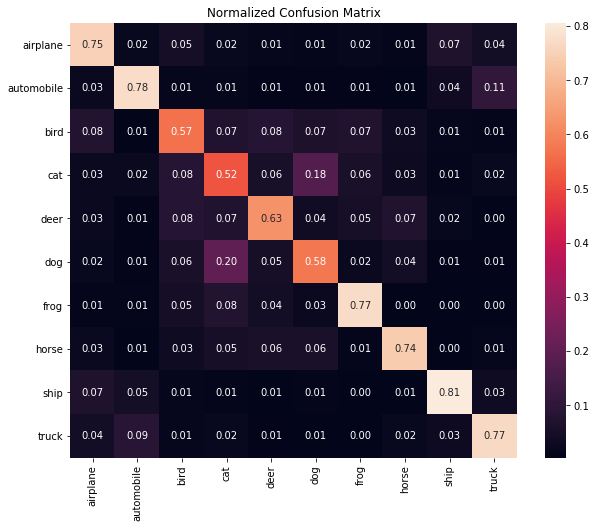

In [9]:
testPredict = classifier.predict(features_Test_final)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
file, im = plt.subplots(figsize = (10, 8))
C = confusion_matrix(testLabel, testPredict)
C = C / 1000
im.set_xlabel('Predicted Label')
im.set_ylabel('True Label')
sns.heatmap(C, annot=True, ax = im, fmt ='.2f')
im.set_title('Normalized Confusion Matrix')
im.set_xticklabels(labels, rotation=90)
im.set_yticklabels(labels, rotation=0)
file.savefig('Confusion Matrix.jpg', dpi=100, bbox_inches='tight')

Generate Exemplary Confusion Images 

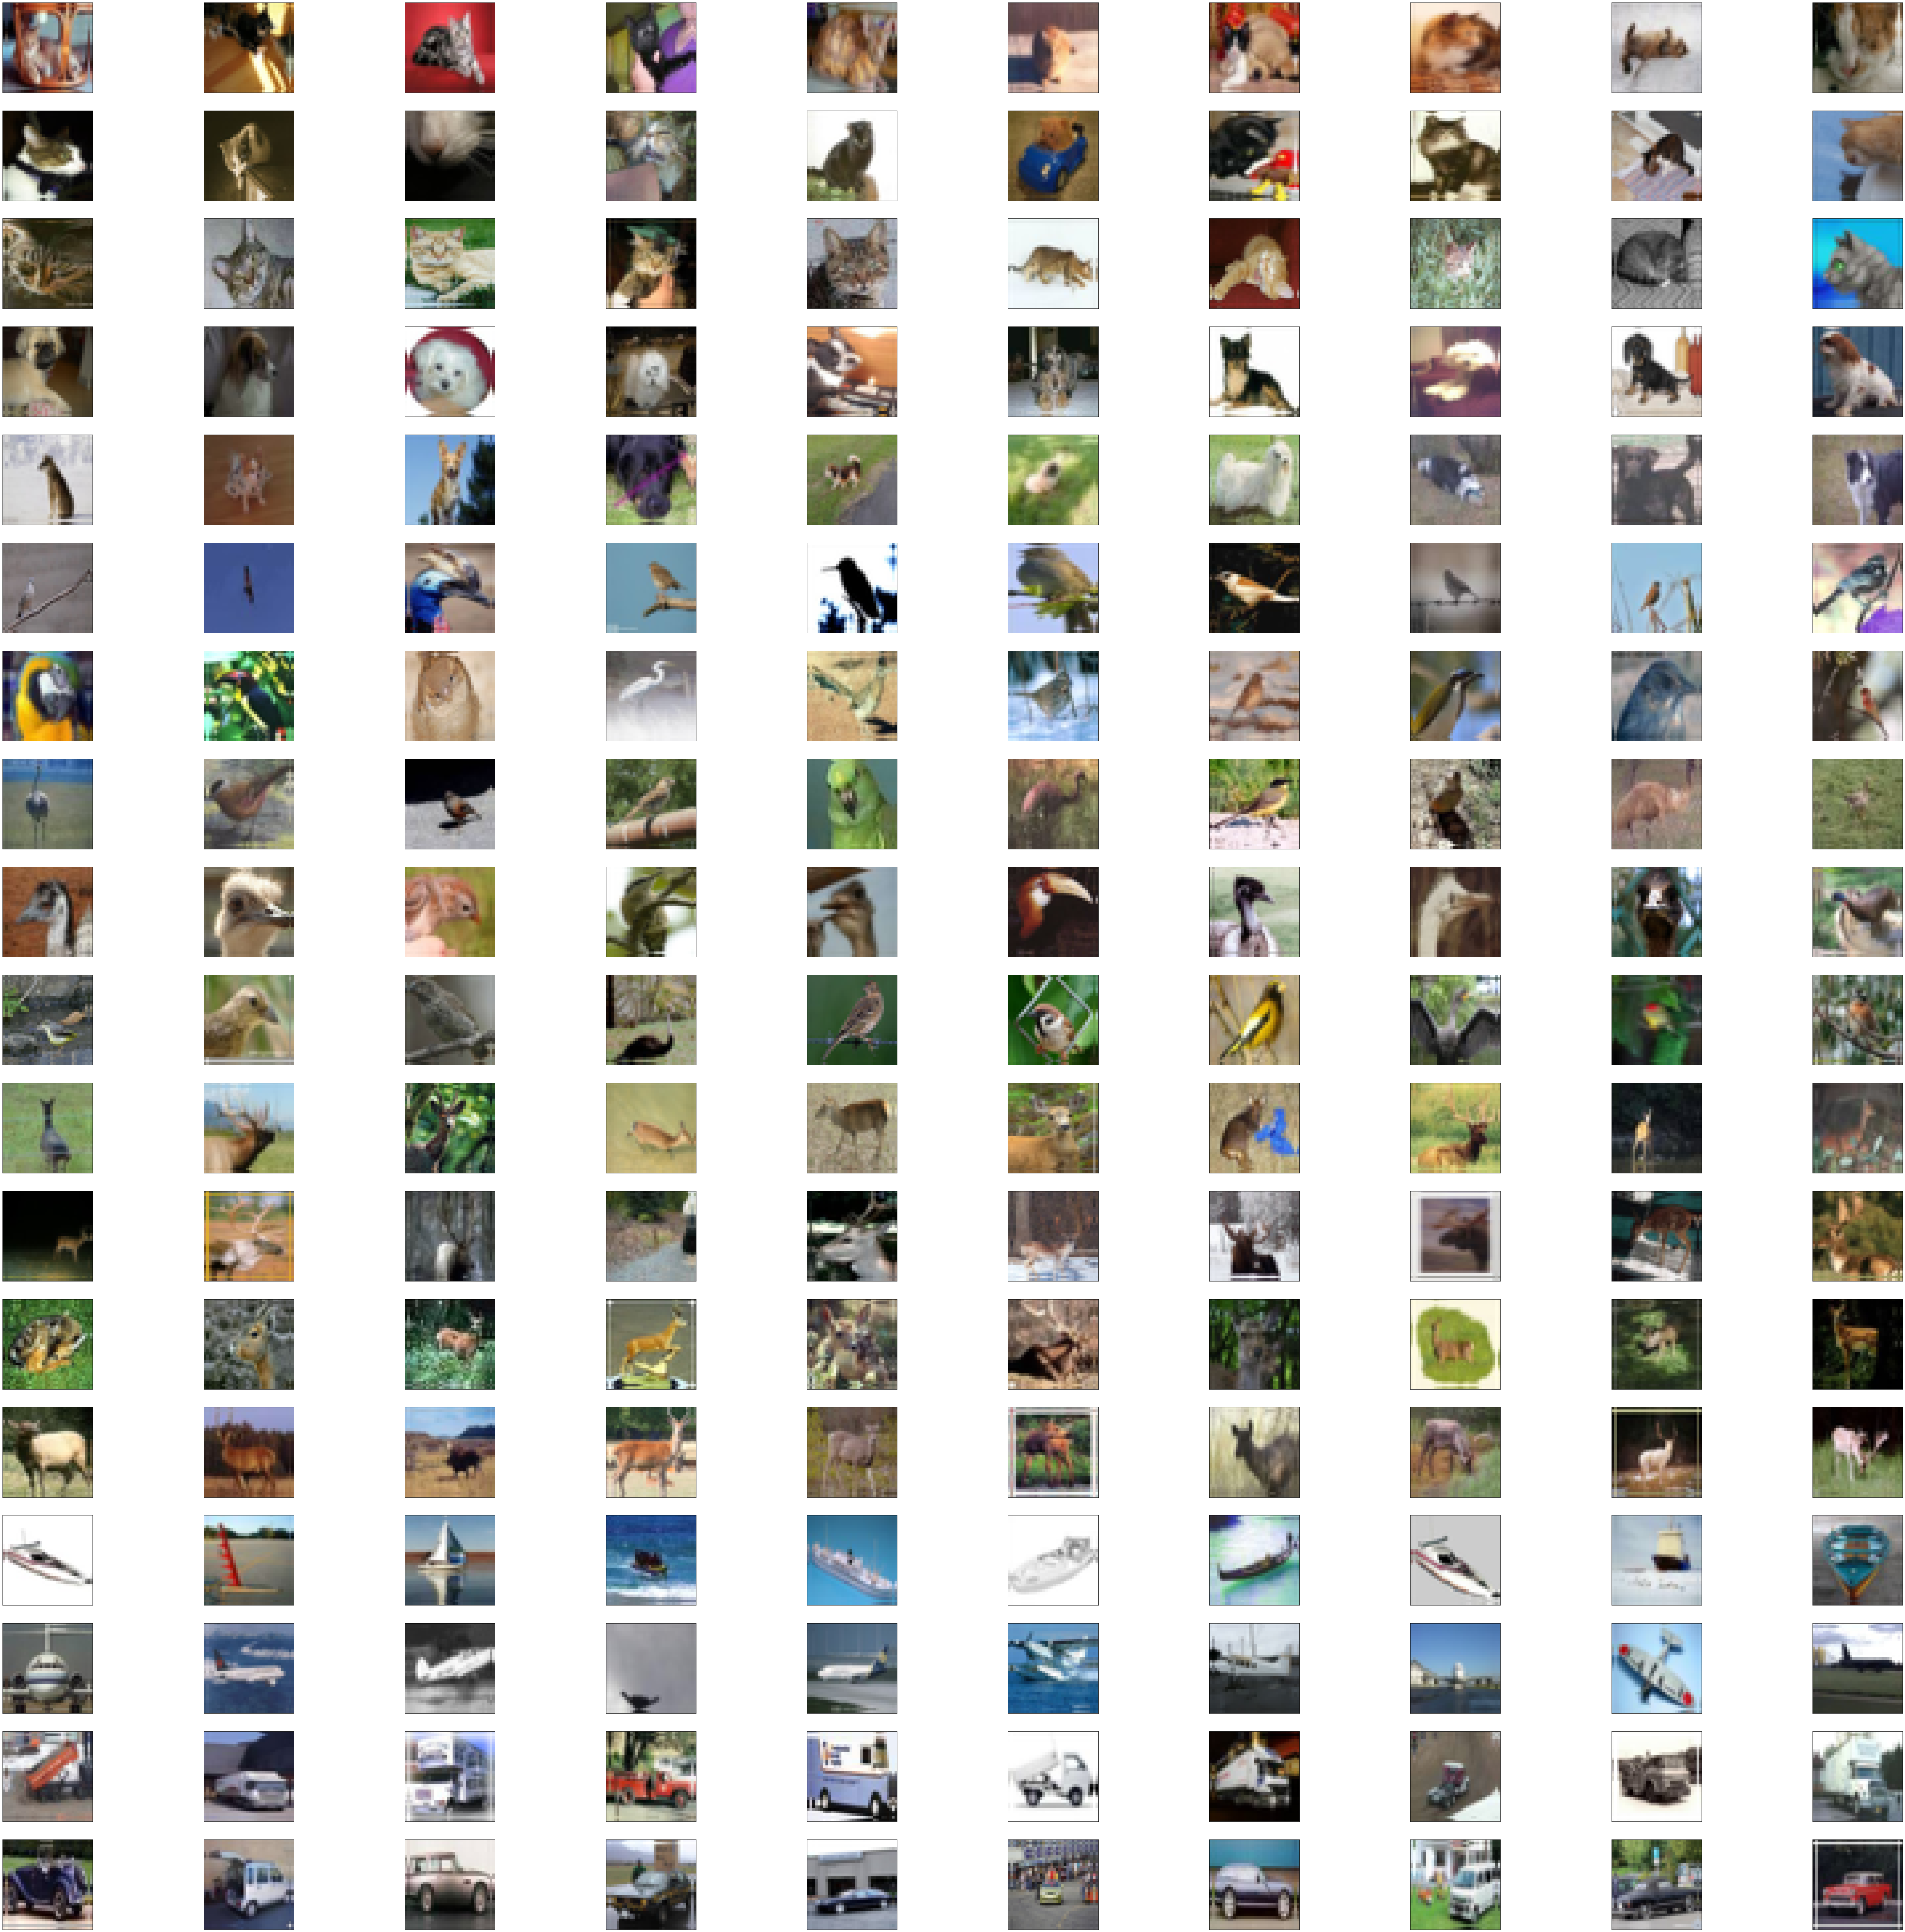

In [10]:
errFile, ax = plt.subplots(18,10,squeeze=True, figsize = (100,100))
count = 0
fname = 'err.jpg'
trueLabel = [3,3,3,5,5,2,2,2,2,2,4,4,4,4,8,0,9,1]
predLabel = [5,2,6,3,2,0,3,4,5,6,2,3,6,7,0,8,1,9]
for i in range(18):
    count = 0
    index = []
    for j in range(10000):
        if (testLabel[j] == trueLabel[i] and testPredict[j] == predLabel[i]):
            index.append(j)
    use = random.sample(index,10)
    for j in use:
        ax[i][count].imshow(testData[j])
        ax[i][count].axes.get_xaxis().set_visible(False)
        ax[i][count].axes.get_yaxis().set_visible(False)
        count = count + 1
errFile.savefig(fname)